# **Tarea 4: Redes Neuronales Artificiales**
**Nombre:** José Luis Cádiz

**ReadMe:** Ejecutar todo el código, si se ejecuta solo una parte aislada pueden existir errores producto de que hay variables que se sobreescriben. 

# **Introducción:**

**En el contexto del curso ''Inteligencia Computacional'', se presentará a continuación el desarrollo de la ''Tarea 4'' del curso. Esta tarea pretende implementar un clasificador de fallas de motores basado en análisis de 
señales de corriente, mediante redes neuronales artificiales. Se utilizará la base de datos Dataset for Sensorless Drive Diagnosis Data Set, que es una base de datos tomadas del UC Irvine Machine Learning Repository. Contiene 48 características extraídas de la señal de corriente que alimenta a un 
motor síncrono y hay 11 clases. Se usará pytorch para entrenar y validar la red neuronal que implementa el clasificador de fallas y también se usaran las librerías pandas, numpy, matplotlib, seaborn y scikit-learn para manipular, procesar y graficar los datos.**

**A continuación se explica a grandes razgos lo que se realizará en la tarea: En la parte 1, se ejecutará el código base entregado, este código carga los
archivos “sensorless_tarea4_train.txt” y “sensorless_tarea4_test.txt” en dos DataFrames, los cuales 
son usados a continuación para generar dos objetos Dataset. Los conjuntos de entrenamiento, 
validación y prueba tendrán DataLoaders, los cuales permiten acceder a los elementos de los 
Datasets mediante batches. Además, los datos se normalizaran. Finalmente, el código base permite 
entrenar una red neuronal, pero se deberá implementar la funcionalidad que evite el 
sobreajuste (overfitting) de la misma.**

**En la parte 2, se entrenará una red neuronal para diversos escenarios considerando una capa de entrada de dimensionalidad 48 (correspondiente a los datos de entrada), capas ocultas (una o dos) y capa de salida con 11 neuronas. Además se deberá evitar el sobreajuste (overfitting) de la red y se mostraran los Loss en función de las epocas de entrenamiento, matrices de confusión y accuracies para el conjunto de entrenamiento y validación.** 

**En la parte 3, usando la mejor red encontrada en validación (aquella con mayor accuracy en validación), se calculará la 
matriz de confusión normalizada y el accuracy normalizado, usando el conjunto de prueba.**

**En la parte 4, se análizaran de los resultados obtenidos explicando los efectos de variar la cantidad de neuronas en la capa oculta, la cantidad de capas ocultas y la función de activación en el desempeño de la red. Luego se análizaran los tiempos de entrenamiento, matrices de confusión y accuracies de 
las arquitecturas probadas en el conjunto de validación y prueba.**


**Finalmente, se termina el documento con las conclusiones principales de esta experiencia.**

# **Importando librerias:**

In [ ]:
# Importando librerias:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

# Libreria sklearn:
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

# Seaborn:
import seaborn as sns

# Para el calculo de tiempos de entrenamiento:
import time


**Parte 1**

**1)** Ejecute el código base entregado e indique si se ejecutó adecuadamente. Este código carga los
archivos “sensorless_tarea4_train.txt” y “sensorless_tarea4_test.txt” en dos DataFrames, los cuales 
son usados a continuación para generar dos objetos Dataset. Los conjuntos de entrenamiento, 
validación y prueba tienen DataLoaders, los cuales permiten acceder a los elementos de los 
Datasets mediante batches. Además, los datos se normalizan. Finalmente, el código base permite 
entrenar una red neuronal, aunque se deberán implementar las funcionalidades que eviten el 
sobreajuste (overfitting) de la misma.

**Código Base:**

In [ ]:
import pandas as pd
import torch
import torch.nn as nn

import numpy as np

from torch.utils.data import random_split

import sys

## Subir datasets de fallas de corriente

In [ ]:
# Se sube el conjunto train, que será posteriormente divido en conjunto de entrenamiento y validación:
from google.colab import files
uploaded = files.upload()  # sensorless_tarea4_train.txt

Saving sensorless_tarea4_train.txt to sensorless_tarea4_train.txt


In [ ]:
# Se sube el conjunto test:
from google.colab import files
uploaded = files.upload()  # sensorless_tarea4_test.txt

Saving sensorless_tarea4_test.txt to sensorless_tarea4_test.txt


## Leer datasets de fallas de corriente

In [ ]:
# Se muestran los conjuntos disponibles:
!ls

sample_data  sensorless_tarea4_test.txt  sensorless_tarea4_train.txt


In [ ]:
# Nombre de las columnas y se agregar el nombre de la columna 'class':
column_names = ["feat" + str(i) for i in range(48)]
column_names.append("class")

In [ ]:
# Se lee el conjunto train como DataFrame:
df_train_val = pd.read_csv('sensorless_tarea4_train.txt', names = column_names)
df_train_val["class"] = df_train_val["class"] - 1   


In [ ]:
# Se lee el conjunto test como DataFrame:
df_test = pd.read_csv('sensorless_tarea4_test.txt', names = column_names)
df_test["class"] = df_test["class"] - 1

## Crear modelo

In [ ]:
# Implementación de red lineal:
model = nn.Sequential(
          nn.Linear(48, 11)
        )

In [ ]:
device = torch.device('cuda')  #Uso de GPU

model = model.to(device)

criterion = nn.CrossEntropyLoss()  #Función de perdida
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)  #Optimizador

## Crear datasets y dataloaders para pytorch

In [ ]:
# Se crean los datasets:

feats_train_val = df_train_val.to_numpy()[:,0:48].astype(np.float32)
labels_train_val = df_train_val.to_numpy()[:,48].astype(int)
dataset_train_val = [ {"features":feats_train_val[i,:], "labels":labels_train_val[i]} for i in range(feats_train_val.shape[0]) ]

feats_test = df_test.to_numpy()[:,0:48].astype(np.float32)
labels_test = df_test.to_numpy()[:,48].astype(int)
dataset_test = [ {"features":feats_test[i,:], "labels":labels_test[i]} for i in range(feats_test.shape[0]) ]

n_train = int(df_train_val.shape[0]*0.85)
n_val = df_train_val.shape[0] - n_train

dataset_train, dataset_val = random_split(dataset_train_val, [n_train, n_val])

In [ ]:
# Se normalizan los datos:

fdata = []
i = 0

for x in dataset_train:
  fdata.append(x['features'])

fdata = np.array(fdata)

fmean= np.mean(fdata, axis=0)
fstd = np.std(fdata, axis=0)

for x in dataset_train:
  x['features'] = (x['features']-fmean) / fstd

for x in dataset_val:
  x['features'] = (x['features']-fmean) / fstd

for x in dataset_test:
  x['features'] = (x['features']-fmean) / fstd


In [ ]:
# Se crean dataloaders:
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=128, shuffle=True, num_workers=0)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=128, shuffle=True, num_workers=0)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=128, shuffle=True, num_workers=0)

## Entrenamiento
Se puede interrumpir con: Entorno de Ejecución -> interrumpir la ejecución

In [ ]:
# Se entrena sobre 1000 épocas:

for epoch in range(1000):
    try:
      sys.stdout.write("\rÉpoca %d  "  %(epoch)) # Se muestra la época actual
      model.train()

      # Entrenamiento de la epoca actual
      for i, data in enumerate(dataloader_train, 0):
          inputs = data["features"].to(device)
          labels = data["labels"].to(device)

          # zero the parameter gradients
          optimizer.zero_grad()

          # Etapa forward + backward + optimize
          outputs = model(inputs)

          loss = criterion(outputs, labels) # Se Calcula el Loss
          loss.backward()
          optimizer.step()

      # Compute validation loss and accuracy for current epoch
      model.eval()

      with torch.no_grad():  
        for i, data in enumerate(dataloader_val, 0):
            inputs = data["features"].to(device)
            labels = data["labels"].to(device)

            outputs = model(inputs)
            # Calcular loss de validación
            
      # Imprimir: numero de época, loss de entrenamiento y loss de validación
      # Se debe usar sys.stdout.write() para que la línea de texto se sobreescriba en vez de imprimirse línea por línea
      # No se debe guardar checkpoints en cada época (guardarlos cada 50 épocas)

    except KeyboardInterrupt:
      print("\nEntrenamiento interrumpido")
      break

print('\nEntrenamiento finalizado')

Época 999  
Entrenamiento finalizado


**Código ejecutado correctamente**

**Parte 2**

Entrene una red neuronal para cada uno de los siguientes casos:

a) 10 neuronas en la capa oculta, usando función de activación ReLU y 1000 épocas. 

b) 40 neuronas en la capa oculta y función de activación ReLU, y 1000 épocas.

c) 10 neuronas en la capa oculta y función de activación Tanh, y 1000 épocas.

d) 40 neuronas en la capa oculta y función de activación Tanh, y 1000 épocas.

e) 2 capas ocultas con 10 y 10 neuronas cada una y función de activación ReLU, y 1000 épocas.

f) 2 capas ocultas con 40 y 40 neuronas cada una y función de activación ReLU, y 1000 épocas.

Para cada red a ser entrenada:

i) Calcule el loss de entrenamiento y el de validación, así como el tiempo de procesamiento 
requerido. El entrenamiento se debe finalizar cuando el loss de validación comience a subir, 
para evitar sobreajuste de la red.

ii) Grafique el loss de entrenamiento y el de validación en función del tiempo. Ambas curvas deben mostrarse en un mismo gráfico, colocando las leyendas adecuadas.

iii) Genere la matriz de confusión normalizada y el accuracy normalizado, usando el conjunto de 
entrenamiento. Se debe mostrar la matriz de confusión con distintos colores o tonos de gris
según el valor del accuracy. La matriz se debe calcular usando scikit-learn, usando la opción 
normalize = "true".

iv) Genere la matriz de confusión normalizada y el accuracy normalizado, usando el conjunto de 
validación. Se debe mostrar la matriz de confusión con distintos colores según el valor del 
accuracy.


 **a)**

In [ ]:
# Diseño del modelo de red:
model_a = nn.Sequential(
          nn.Linear(48, 10),
          nn.ReLU(),
          nn.Linear(10, 11)
)

In [ ]:
device = torch.device('cuda')

model_a = model_a.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_a.parameters(), lr=1e-3)

In [ ]:
# Entrenamiento:
lista_loss_epoca_train=[] # Listas de Loss por época para el conjunto de entrenamiento
lista_loss_epoca_val=[] # Listas de Loss por época para el conjunto de validación
T1=time.time() # Tiempo Inicial
for epoch in range(1000):
    try:
      model_a.train()
      # Train on the current epoch
      lista_loss_train=[] # Lista para guardar los Loss de cada batch
      for i, data in enumerate(dataloader_train, 0): #Se itera sobre cada batch
          inputs = data["features"].to(device)
          labels = data["labels"].to(device)

          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = model_a(inputs) # Clasificación

          loss_train = criterion(outputs, labels) # Loss entrenamiento
          lista_loss_train.append(loss_train.item()) # Se guardan loss de cada batch
          loss_train.backward()
          optimizer.step()
      
      # Compute validation loss and accuracy for current epoch
      model_a.eval()

      with torch.no_grad():  
        lista_loss_val=[] #Lista para guardar los Loss de cada batch
        for i, data in enumerate(dataloader_val, 0):
            inputs = data["features"].to(device)
            labels = data["labels"].to(device)

            outputs = model_a(inputs) # Clasificación
            loss_val = criterion(outputs, labels) #Loss validación
            lista_loss_val.append(loss_val.item())
                 
      lista_loss_epoca_train.append(np.mean(lista_loss_train))  # Se promedian los Loss de los batch de cada epoca para obtener el Loss por época
      lista_loss_epoca_val.append(np.mean(lista_loss_val))

      # Imprimir: numero de época, loss de entrenamiento y loss de validación:
      sys.stdout.write("\rÉpoca %d , loss train: %.2f, loss validacion:%.2f"  %(epoch,lista_loss_epoca_train[epoch],lista_loss_epoca_val[epoch]))
      
      #Check Point pesos sinapticos cada 50 épocas:
      if epoch%50==0:
        name="epoch_a_"+str(epoch)
        torch.save(model_a,name)
        modelo_check_a=name  #Se guarda el último modelo guardado
        epoca_check=epoch  #Se guarda la última epoca en donde se hizo check point para el grafico de Loss
      
      #Frenado overfitting:
      if epoch>=50:
        inicial_lista=lista_loss_epoca_val[epoch-50:epoch] # Lista con los Loss anteriores para época i-1
        final_lista=lista_loss_epoca_val[epoch-49:epoch+1] # Lista con los Loss anteriores para época i
        inicial=np.mean(inicial_lista) # Se obtiene el promedio de las 50 épocas de i-1
        final=np.mean(final_lista) # Se obtiene el promedio de las 50 épocas de i
        if final-inicial>0: # Si el promedio de i es mayor a i-1, el Loss efectivamente estará creciendo, por lo que se deja de entrenar
          #Fin de Entrenamiento
          break
      
      
    except KeyboardInterrupt:
      print("\nEntrenamiento interrumpido")

      break
    

print('\nEntrenamiento finalizado')

#Tiempo de entrenamiento:
T2=time.time()
Ta=T2-T1
print('Tiempo de entrenamiento: ' + str(round(Ta,1))+'[s]')

Época 269 , loss train: 0.14, loss validacion:0.17
Entrenamiento finalizado
Tiempo de entrenamiento: 13.9[s]


**Para las siguientes partes de entrenamiento no se vuelve a enfatizar en la explicación del código ya que es analogo al anteriormente explicado.**

In [ ]:
# i)
print('Epoca ultimo Check Point: '+str(epoca_check))
print('Loss train ultimo Check Point: {:.2f} '.format(lista_loss_epoca_train[epoca_check]))  
print('Loss validacion ultimo Check Point: {:.2f} '.format(lista_loss_epoca_val[epoca_check]))
print('Tiempo de entrenamiento: '+str(round(Ta,1))+'[s]')


Epoca ultimo Check Point: 250
Loss train ultimo Check Point: 0.15 
Loss validacion ultimo Check Point: 0.17 
Tiempo de entrenamiento: 13.9[s]


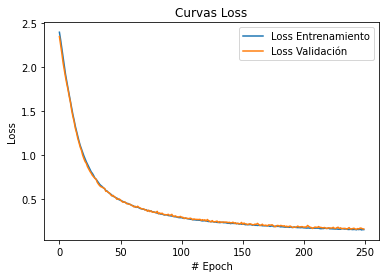

In [ ]:
# ii)
epocas=[i for i in range(0,epoca_check)]  # Lista con épocas hasta el ultimo Check Point para poder graficar
plt.plot(epocas,lista_loss_epoca_train[0:epoca_check]) # Plot entrenamiento
plt.plot(epocas,lista_loss_epoca_val[0:epoca_check]) # Plot validación
plt.legend(["Loss Entrenamiento","Loss Validación"], loc ="upper right")
plt.title('Curvas Loss')
plt.xlabel('# Epoch')
plt.ylabel('Loss')
plt.show()

**Curva Loss de validación es mayor a la curva Loss de entrenamiento, lo cual concuerda con la teoría.**

In [ ]:
# iii)
# Conjunto de entrenamiento:
model_a_check = torch.load(modelo_check_a) #Carga el modelo del último Check Point
y_pred=[] # Lista para guardar predicción de clasificación
y_true=[] # Lista para guardar clasificación verdadera
model_a_check.eval()
with torch.no_grad():
  for i, data in enumerate(dataloader_train, 0): # Iteración sobre batch conjunto de entrenamiento
    inputs = data["features"].to(device) # Features
    labels = data["labels"].to(device)   # Labels
    true=labels.cpu().tolist()    # Guardamos los labels como listas en la variable "true"
    y_true.extend(true)  # Luego esta se incorpora a la lista "y_true"
    outputs = model_a_check(inputs) # Se obtiene la salida de la red neuronal
    output=outputs.cpu().numpy()  # outputs se transforman de tensor a numpy
    list=[] # Lista para guardar clasificaciones de la red neuronal
    for i in range(len(output)): # Para cada fila de la matriz clasificacion, se obtiene el indice asociado al valor máximo de la salida
        list.append(np.argmax(output[i])) # Se obtiene la clasificacion, la cual se guarda en "list"
    y_pred.extend(list) # Una vez que la lista es llenada con el batch completo, esta es concatenada en "y_pred"

Accuracy: 0.9551361386138614



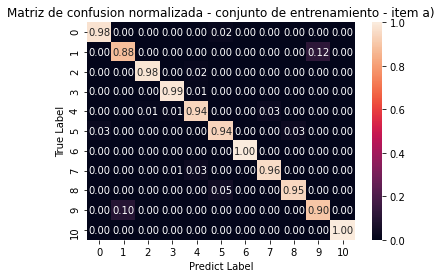

In [ ]:
# Datos de la matriz de confusión:
Confusion=confusion_matrix(y_true, y_pred,normalize='true') 

# Matriz de confusión:
ax=sns.heatmap(Confusion, annot=True,fmt=".2f")
ax.set_title('Matriz de confusion normalizada - conjunto de entrenamiento - item a)')
plt.xlabel('Predict Label')
plt.ylabel('True Label')

# Accuracy:
Accuracy_a= metrics.accuracy_score(y_true, y_pred)
print('Accuracy: '+str(Accuracy_a))
print('')

In [ ]:
# iv)
# Conjunto de validación:
model_a_check = torch.load(modelo_check_a) #Carga el modelo
y_pred=[]
y_true=[]
model_a_check.eval()
with torch.no_grad():
  for i, data in enumerate(dataloader_val, 0):
    inputs = data["features"].to(device) # Features
    labels = data["labels"].to(device)   # Labels
    true=labels.cpu().tolist()    # Guardamos los labels como listas en la variable "true"
    y_true.extend(true)  # Luego esta se incorpora a la lista "y_true"
    outputs = model_a_check(inputs) # Se obtiene la salida de la red neuronal
    output=outputs.cpu().numpy()  # outputs se transforman de tensor a numpy
    list=[]
    for i in range(len(output)): # Para cada fila de la matriz clasificacion, se obtiene el indice asociado al valor maximo de la salida
        list.append(np.argmax(output[i])) # Se obtiene la clasificacion, la cual se guarda en "list"
    y_pred.extend(list) # Una vez que la lista es llenada con el batch completo, esta es concatenada en "y_pred"

Accuracy: 0.9422066549912435



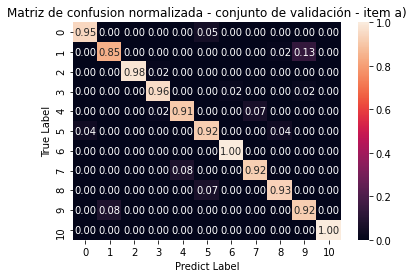

In [ ]:
# Datos de la matriz de confusión:
Confusion=confusion_matrix(y_true, y_pred,normalize='true') 

# Matriz de confusión:
ax=sns.heatmap(Confusion, annot=True,fmt=".2f")
ax.set_title('Matriz de confusion normalizada - conjunto de validación - item a)')
plt.xlabel('Predict Label')
plt.ylabel('True Label')

# Accuracy:
Accuracy_a= metrics.accuracy_score(y_true, y_pred)
print('Accuracy: '+str(Accuracy_a))
print('')

**Accuracy para el conjunto de validación disminuye respecto al calculado para el conjunto de entrenamiento y el desempeño de la matriz de confusión para validación también disminuye respecto al de entrenamiento, lo cual concuerda con la teoría al clasificar datos nuevos con los cuales no se entreno.**

**El código explicado para los requerimientos i al iv no se explicarán con tanto enfasis en las proximas partes, ya que el código es análogo.**

**b)**

In [ ]:
# Diseño del modelo:
model_b = nn.Sequential(
          nn.Linear(48, 40),
          nn.ReLU(),
          nn.Linear(40, 11)
)

In [ ]:
device = torch.device('cuda')

model_b = model_b.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_b.parameters(), lr=1e-3)

In [ ]:
# Código explicado en item a)
lista_loss_epoca_train=[]
lista_loss_epoca_val=[]
T1=time.time()
for epoch in range(1000):
    try:
      model_b.train()
      # Train on the current epoch
      lista_loss_train=[]
      for i, data in enumerate(dataloader_train, 0):
          inputs = data["features"].to(device)
          labels = data["labels"].to(device)

          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = model_b(inputs)

          loss_train = criterion(outputs, labels) #Loss entrenamiento
          lista_loss_train.append(loss_train.item())
          loss_train.backward()
          optimizer.step()
      
      # Compute validation loss and accuracy for current epoch
      model_b.eval()

      with torch.no_grad():  
        lista_loss_val=[]
        for i, data in enumerate(dataloader_val, 0):
            inputs = data["features"].to(device)
            labels = data["labels"].to(device)

            outputs = model_b(inputs)
            loss_val = criterion(outputs, labels) #Loss validación
            lista_loss_val.append(loss_val.item())
                 
      lista_loss_epoca_train.append(np.mean(lista_loss_train))
      lista_loss_epoca_val.append(np.mean(lista_loss_val))

      # Imprimir: numero de época, loss de entrenamiento y loss de validación:
      sys.stdout.write("\rÉpoca %d , loss train: %.2f, loss validacion:%.2f"  %(epoch,lista_loss_epoca_train[epoch],lista_loss_epoca_val[epoch]))
      
      #Check Point pesos sinapticos cada 50 épocas:
      if epoch%50==0:
        name="epoch_b_"+str(epoch)
        torch.save(model_b,name)
        modelo_check_b=name  #Se guarda el ultimo modelo guardado
        epoca_check=epoch  #Se guarda la ultima epoca en donde se hizo check point para el grafico de Loss
      
      #Frenado overfitting:
      if epoch>=50:
        inicial_lista=lista_loss_epoca_val[epoch-50:epoch]
        final_lista=lista_loss_epoca_val[epoch-49:epoch+1]
        inicial=np.mean(inicial_lista)
        final=np.mean(final_lista)
        if final-inicial>0:
          #Fin de Entrenamiento
          break
      
      
    except KeyboardInterrupt:
      print("\nEntrenamiento interrumpido")

      break
    

print('\nEntrenamiento finalizado')

#Tiempo de entrenamiento:
T2=time.time()
Tb=T2-T1
print('Tiempo de entrenamiento: ' + str(round(Tb,1))+'[s]')

Época 161 , loss train: 0.05, loss validacion:0.14
Entrenamiento finalizado
Tiempo de entrenamiento: 8.5[s]


In [ ]:
# i)
print('Epoca ultimo Check Point: '+str(epoca_check))
print('Loss train ultimo Check Point: {:.2f} '.format(lista_loss_epoca_train[epoca_check]))  
print('Loss validacion ultimo Check Point: {:.2f} '.format(lista_loss_epoca_val[epoca_check]))
print('Tiempo de entrenamiento: '+str(round(Tb,1))+'[s]')


Epoca ultimo Check Point: 150
Loss train ultimo Check Point: 0.05 
Loss validacion ultimo Check Point: 0.12 
Tiempo de entrenamiento: 8.5[s]


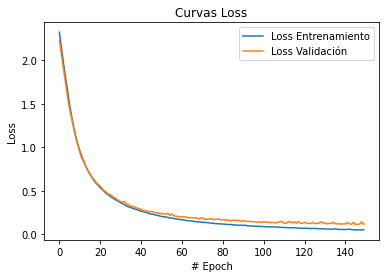

In [ ]:
# ii)
epocas=[i for i in range(0,epoca_check)]
plt.plot(epocas,lista_loss_epoca_train[0:epoca_check])
plt.plot(epocas,lista_loss_epoca_val[0:epoca_check])
plt.legend(["Loss Entrenamiento","Loss Validación"], loc ="upper right")
plt.title('Curvas Loss')
plt.xlabel('# Epoch')
plt.ylabel('Loss')
plt.show()

**Curva Loss de validación es mayor a la curva Loss de entrenamiento, lo cual concuerda con la teoría.**

In [ ]:
# iii)
# Conjunto de entrenamiento:
model_b_check = torch.load(modelo_check_b) #Carga el modelo
y_pred=[]
y_true=[]
model_b_check.eval()
with torch.no_grad():
  for i, data in enumerate(dataloader_train, 0):
    inputs = data["features"].to(device) # Features
    labels = data["labels"].to(device)   # Labels
    true=labels.cpu().tolist()    # Guardamos los labels como listas en la variable "true"
    y_true.extend(true)  # Luego esta se incorpora a la lista "y_true"
    outputs = model_b_check(inputs) # Se obtiene la salida de la red neuronal
    output=outputs.cpu().numpy()  # outputs se transforman de tensor a numpy
    list=[]
    for i in range(len(output)): # Para cada fila de la matriz clasificacion, se obtiene el indice asociado al valor maximo de la salida
        list.append(np.argmax(output[i])) # Se obtiene la clasificacion, la cual se guarda en "list"
    y_pred.extend(list) # Una vez que la lista es llenada con el batch completo, esta es concatenada en "y_pred"

Accuracy: 0.9938118811881188



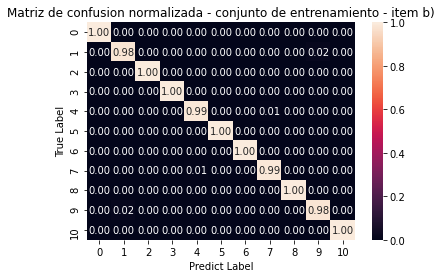

In [ ]:
# Datos de la matriz de confusión:
Confusion=confusion_matrix(y_true, y_pred,normalize='true') 

# Matriz de confusión:
ax=sns.heatmap(Confusion, annot=True,fmt=".2f")
ax.set_title('Matriz de confusion normalizada - conjunto de entrenamiento - item b)')
plt.xlabel('Predict Label')
plt.ylabel('True Label')

# Accuracy:
Accuracy_b= metrics.accuracy_score(y_true, y_pred)
print('Accuracy: '+str(Accuracy_b))
print('')

In [ ]:
# iv)
# Conjunto de validación:
model_b_check = torch.load(modelo_check_b) #Carga el modelo
y_pred=[]
y_true=[]
model_b_check.eval()
with torch.no_grad():
  for i, data in enumerate(dataloader_val, 0):
    inputs = data["features"].to(device) # Features
    labels = data["labels"].to(device)   # Labels
    true=labels.cpu().tolist()    # Guardamos los labels como listas en la variable "true"
    y_true.extend(true)  # Luego esta se incorpora a la lista "y_true"
    outputs = model_b_check(inputs) # Se obtiene la salida de la red neuronal
    output=outputs.cpu().numpy()  # outputs se transforman de tensor a numpy
    list=[]
    for i in range(len(output)): # Para cada fila de la matriz clasificacion, se obtiene el indice asociado al valor maximo de la salida
        list.append(np.argmax(output[i])) # Se obtiene la clasificacion, la cual se guarda en "list"
    y_pred.extend(list) # Una vez que la lista es llenada con el batch completo, esta es concatenada en "y_pred"

Accuracy: 0.9667250437828371



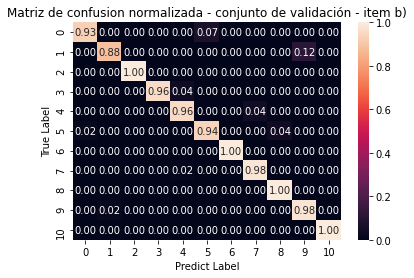

In [ ]:
# Datos de la matriz de confusión:
Confusion=confusion_matrix(y_true, y_pred,normalize='true') 

# Matriz de confusión:
ax=sns.heatmap(Confusion, annot=True,fmt=".2f")
ax.set_title('Matriz de confusion normalizada - conjunto de validación - item b)')
plt.xlabel('Predict Label')
plt.ylabel('True Label')

# Accuracy:
Accuracy_b= metrics.accuracy_score(y_true, y_pred)
print('Accuracy: '+str(Accuracy_b))
print('')

**Accuracy para el conjunto de validación disminuye respecto al calculado para el conjunto de entrenamiento y el desempeño de la matriz de confusión para validación también disminuye respecto al de entrenamiento, lo cual concuerda con la teoría al clasificar datos nuevos con los cuales no se entreno.**

**c)**

In [ ]:
# Diseño de la red:
model_c = nn.Sequential(
          nn.Linear(48, 10),
          nn.Tanh(),
          nn.Linear(10, 11)
)

In [ ]:
device = torch.device('cuda')

model_c = model_c.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_c.parameters(), lr=1e-3)

In [ ]:
lista_loss_epoca_train=[]
lista_loss_epoca_val=[]
T1=time.time()
for epoch in range(1000):
    try:
      model_c.train()
      # Train on the current epoch
      lista_loss_train=[]
      for i, data in enumerate(dataloader_train, 0):
          inputs = data["features"].to(device)
          labels = data["labels"].to(device)

          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = model_c(inputs)

          loss_train = criterion(outputs, labels) #Loss entrenamiento
          lista_loss_train.append(loss_train.item())
          loss_train.backward()
          optimizer.step()
      
      # Compute validation loss and accuracy for current epoch
      model_c.eval()

      with torch.no_grad():  
        lista_loss_val=[]
        for i, data in enumerate(dataloader_val, 0):
            inputs = data["features"].to(device)
            labels = data["labels"].to(device)

            outputs = model_c(inputs)
            loss_val = criterion(outputs, labels) #Loss validación
            lista_loss_val.append(loss_val.item())
                 
      lista_loss_epoca_train.append(np.mean(lista_loss_train))
      lista_loss_epoca_val.append(np.mean(lista_loss_val))

      # Imprimir: numero de época, loss de entrenamiento y loss de validación:
      sys.stdout.write("\rÉpoca %d , loss train: %.2f, loss validacion:%.2f"  %(epoch,lista_loss_epoca_train[epoch],lista_loss_epoca_val[epoch]))
      
      #Check Point pesos sinapticos cada 50 épocas:
      if epoch%50==0:
        name="epoch_c_"+str(epoch)
        torch.save(model_c,name)
        modelo_check_c=name  #Se guarda el ultimo modelo guardado
        epoca_check=epoch  #Se guarda la ultima epoca en donde se hizo check pointcorta para el grafico de Loss
      
      #Frenado overfitting:
      if epoch>=50:
        inicial_lista=lista_loss_epoca_val[epoch-50:epoch]
        final_lista=lista_loss_epoca_val[epoch-49:epoch+1]
        inicial=np.mean(inicial_lista)
        final=np.mean(final_lista)
        if final-inicial>0:
          #Fin de Entrenamiento
          break
      
      
    except KeyboardInterrupt:
      print("\nEntrenamiento interrumpido")

      break
    

print('\nEntrenamiento finalizado')

#Tiempo de entrenamiento:
T2=time.time()
Tc=T2-T1
print('Tiempo de entrenamiento: ' + str(round(Tc,1))+'[s]')

Época 267 , loss train: 0.20, loss validacion:0.21
Entrenamiento finalizado
Tiempo de entrenamiento: 14.1[s]


In [ ]:
# i)
print('Epoca ultimo Check Point: '+str(epoca_check))
print('Loss train ultimo Check Point: {:.2f} '.format(lista_loss_epoca_train[epoca_check]))  
print('Loss validacion ultimo Check Point: {:.2f} '.format(lista_loss_epoca_val[epoca_check]))
print('Tiempo de entrenamiento: '+str(round(T2-T1,1))+'[s]')


Epoca ultimo Check Point: 250
Loss train ultimo Check Point: 0.20 
Loss validacion ultimo Check Point: 0.21 
Tiempo de entrenamiento: 14.1[s]


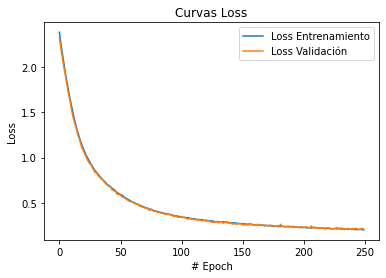

In [ ]:
# ii)
epocas=[i for i in range(0,epoca_check)]
plt.plot(epocas,lista_loss_epoca_train[0:epoca_check])
plt.plot(epocas,lista_loss_epoca_val[0:epoca_check])
plt.legend(["Loss Entrenamiento","Loss Validación"], loc ="upper right")
plt.title('Curvas Loss')
plt.xlabel('# Epoch')
plt.ylabel('Loss')
plt.show()

**Curva Loss de validación es mayor a la curva Loss de entrenamiento, lo cual concuerda con la teoría.**

In [ ]:
# iii)
# Conjunto de entrenamiento:
model_c_check = torch.load(modelo_check_c) #Carga el modelo
y_pred=[]
y_true=[]
model_c_check.eval()
with torch.no_grad():
  for i, data in enumerate(dataloader_train, 0):
    inputs = data["features"].to(device) # Features
    labels = data["labels"].to(device)   # Labels
    true=labels.cpu().tolist()    # Guardamos los labels como listas en la variable "true"
    y_true.extend(true)  # Luego esta se incorpora a la lista "y_true"
    outputs = model_c_check(inputs) # Se obtiene la salida de la red neuronal
    output=outputs.cpu().numpy()  # outputs se transforman de tensor a numpy
    list=[]
    for i in range(len(output)): # Para cada fila de la matriz clasificacion, se obtiene el indice asociado al valor maximo de la salida
        list.append(np.argmax(output[i])) # Se obtiene la clasificacion, la cual se guarda en "list"
    y_pred.extend(list) # Una vez que la lista es llenada con el batch completo, esta es concatenada en "y_pred"

Accuracy: 0.9334777227722773



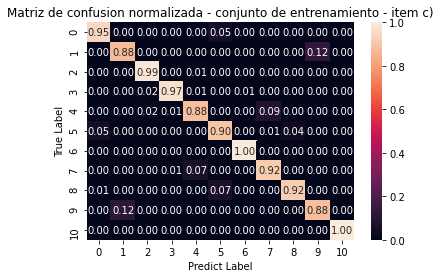

In [ ]:
# Datos de la matriz de confusión:
Confusion=confusion_matrix(y_true, y_pred,normalize='true') 

# Matriz de confusión:
ax=sns.heatmap(Confusion, annot=True,fmt=".2f")
ax.set_title('Matriz de confusion normalizada - conjunto de entrenamiento - item c)')
plt.xlabel('Predict Label')
plt.ylabel('True Label')

# Accuracy:
Accuracy_c= metrics.accuracy_score(y_true, y_pred)
print('Accuracy: '+str(Accuracy_c))
print('')

In [ ]:
# iv)
# Conjunto de validación:
model_c_check = torch.load(modelo_check_c) #Carga el modelo
y_pred=[]
y_true=[]
model_c_check.eval()
with torch.no_grad():
  for i, data in enumerate(dataloader_val, 0):
    inputs = data["features"].to(device) # Features
    labels = data["labels"].to(device)   # Labels
    true=labels.cpu().tolist()    # Guardamos los labels como listas en la variable "true"
    y_true.extend(true)  # Luego esta se incorpora a la lista "y_true"
    outputs = model_c_check(inputs) # Se obtiene la salida de la red neuronal
    output=outputs.cpu().numpy()  # outputs se transforman de tensor a numpy
    list=[]
    for i in range(len(output)): # Para cada fila de la matriz clasificacion, se obtiene el indice asociado al valor maximo de la salida
        list.append(np.argmax(output[i])) # Se obtiene la clasificacion, la cual se guarda en "list"
    y_pred.extend(list) # Una vez que la lista es llenada con el batch completo, esta es concatenada en "y_pred"

Accuracy: 0.9316987740805605



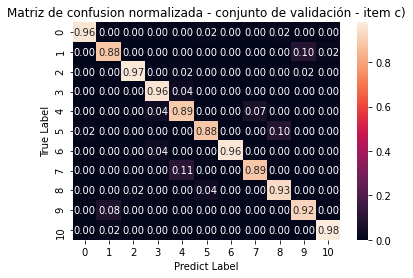

In [ ]:
# Datos de la matriz de confusión:
Confusion=confusion_matrix(y_true, y_pred,normalize='true') 

# Matriz de confusión:
ax=sns.heatmap(Confusion, annot=True,fmt=".2f")
ax.set_title('Matriz de confusion normalizada - conjunto de validación - item c)')
plt.xlabel('Predict Label')
plt.ylabel('True Label')

# Accuracy:
Accuracy_c= metrics.accuracy_score(y_true, y_pred)
print('Accuracy: '+str(Accuracy_c))
print('')

**Accuracy para el conjunto de validación disminuye respecto al calculado para el conjunto de entrenamiento y el desempeño de la matriz de confusión para validación también disminuye respecto al de entrenamiento, lo cual concuerda con la teoría al clasificar datos nuevos con los cuales no se entreno.**

**d)**

In [ ]:
# Diseño de la red:
model_d = nn.Sequential(
          nn.Linear(48, 40),
          nn.Tanh(),
          nn.Linear(40, 11)
)

In [ ]:
device = torch.device('cuda')

model_d = model_d.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_d.parameters(), lr=1e-3)

In [ ]:
lista_loss_epoca_train=[]
lista_loss_epoca_val=[]
T1=time.time()
for epoch in range(1000):
    try:
      model_d.train()
      # Train on the current epoch
      lista_loss_train=[]
      for i, data in enumerate(dataloader_train, 0):
          inputs = data["features"].to(device)
          labels = data["labels"].to(device)

          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = model_d(inputs)

          loss_train = criterion(outputs, labels) #Loss entrenamiento
          lista_loss_train.append(loss_train.item())
          loss_train.backward()
          optimizer.step()
      
      # Compute validation loss and accuracy for current epoch
      model_d.eval()

      with torch.no_grad():  
        lista_loss_val=[]
        for i, data in enumerate(dataloader_val, 0):
            inputs = data["features"].to(device)
            labels = data["labels"].to(device)

            outputs = model_d(inputs)
            loss_val = criterion(outputs, labels) #Loss validación
            lista_loss_val.append(loss_val.item())
                 
      lista_loss_epoca_train.append(np.mean(lista_loss_train))
      lista_loss_epoca_val.append(np.mean(lista_loss_val))

      # Imprimir: numero de época, loss de entrenamiento y loss de validación:
      sys.stdout.write("\rÉpoca %d , loss train: %.2f, loss validacion:%.2f"  %(epoch,lista_loss_epoca_train[epoch],lista_loss_epoca_val[epoch]))
      
      #Check Point pesos sinapticos cada 50 épocas:
      if epoch%50==0:
        name="epoch_d_"+str(epoch)
        torch.save(model_d,name)
        modelo_check_d=name  #Se guarda el ultimo modelo guardado
        epoca_check=epoch  #Se guarda la ultima epoca en donde se hizo check pointcorta para el grafico de Loss
      
      #Frenado overfitting:
      if epoch>=50:
        inicial_lista=lista_loss_epoca_val[epoch-50:epoch]
        final_lista=lista_loss_epoca_val[epoch-49:epoch+1]
        inicial=np.mean(inicial_lista)
        final=np.mean(final_lista)
        if final-inicial>0:
          #Fin de Entrenamiento
          break
      
      
    except KeyboardInterrupt:
      print("\nEntrenamiento interrumpido")

      break
    

print('\nEntrenamiento finalizado')

#Tiempo de entrenamiento:
T2=time.time()
Td=T2-T1
print('Tiempo de entrenamiento: ' + str(round(Td,1))+'[s]')

Época 203 , loss train: 0.04, loss validacion:0.10
Entrenamiento finalizado
Tiempo de entrenamiento: 10.6[s]


In [ ]:
# i)
print('Epoca ultimo Check Point: '+str(epoca_check))
print('Loss train ultimo Check Point: {:.2f} '.format(lista_loss_epoca_train[epoca_check]))  
print('Loss validacion ultimo Check Point: {:.2f} '.format(lista_loss_epoca_val[epoca_check]))
print('Tiempo de entrenamiento: '+str(round(Td,1))+'[s]')


Epoca ultimo Check Point: 200
Loss train ultimo Check Point: 0.04 
Loss validacion ultimo Check Point: 0.10 
Tiempo de entrenamiento: 10.6[s]


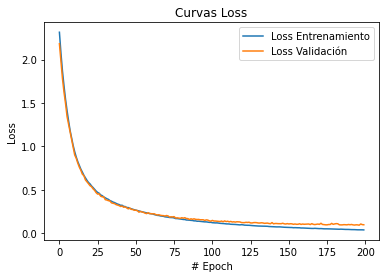

In [ ]:
# ii)
epocas=[i for i in range(0,epoca_check)]
plt.plot(epocas,lista_loss_epoca_train[0:epoca_check])
plt.plot(epocas,lista_loss_epoca_val[0:epoca_check])
plt.legend(["Loss Entrenamiento","Loss Validación"], loc ="upper right")
plt.title('Curvas Loss')
plt.xlabel('# Epoch')
plt.ylabel('Loss')
plt.show()

**Curva Loss de validación es mayor a la curva Loss de entrenamiento, lo cual concuerda con la teoría.**

In [ ]:
# iii)
# Conjunto de entrenamiento:
model_d_check = torch.load(modelo_check_d) #Carga el modelo
y_pred=[]
y_true=[]
model_d_check.eval()
with torch.no_grad():
  for i, data in enumerate(dataloader_train, 0):
    inputs = data["features"].to(device) # Features
    labels = data["labels"].to(device)   # Labels
    true=labels.cpu().tolist()    # Guardamos los labels como listas en la variable "true"
    y_true.extend(true)  # Luego esta se incorpora a la lista "y_true"
    outputs = model_d_check(inputs) # Se obtiene la salida de la red neuronal
    output=outputs.cpu().numpy()  # outputs se transforman de tensor a numpy
    list=[]
    for i in range(len(output)): # Para cada fila de la matriz clasificacion, se obtiene el indice asociado al valor maximo de la salida
        list.append(np.argmax(output[i])) # Se obtiene la clasificacion, la cual se guarda en "list"
    y_pred.extend(list) # Una vez que la lista es llenada con el batch completo, esta es concatenada en "y_pred"

Accuracy: 0.9975247524752475



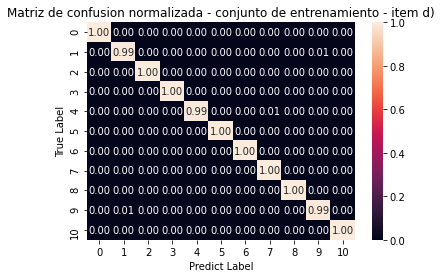

In [ ]:
# Datos de la matriz de confusión:
Confusion=confusion_matrix(y_true, y_pred,normalize='true') 

# Matriz de confusión:
ax=sns.heatmap(Confusion, annot=True,fmt=".2f")
ax.set_title('Matriz de confusion normalizada - conjunto de entrenamiento - item d)')
plt.xlabel('Predict Label')
plt.ylabel('True Label')

# Accuracy:
Accuracy_d= metrics.accuracy_score(y_true, y_pred)
print('Accuracy: '+str(Accuracy_d))
print('')

In [ ]:
# iv)
# Conjunto de validación:
model_d_check = torch.load(modelo_check_d) #Carga el modelo
y_pred=[]
y_true=[]
model_d_check.eval()
with torch.no_grad():
  for i, data in enumerate(dataloader_val, 0):
    inputs = data["features"].to(device) # Features
    labels = data["labels"].to(device)   # Labels
    true=labels.cpu().tolist()    # Guardamos los labels como listas en la variable "true"
    y_true.extend(true)  # Luego esta se incorpora a la lista "y_true"
    outputs = model_d_check(inputs) # Se obtiene la salida de la red neuronal
    output=outputs.cpu().numpy()  # outputs se transforman de tensor a numpy
    list=[]
    for i in range(len(output)): # Para cada fila de la matriz clasificacion, se obtiene el indice asociado al valor maximo de la salida
        list.append(np.argmax(output[i])) # Se obtiene la clasificacion, la cual se guarda en "list"
    y_pred.extend(list) # Una vez que la lista es llenada con el batch completo, esta es concatenada en "y_pred"

Accuracy: 0.9702276707530648



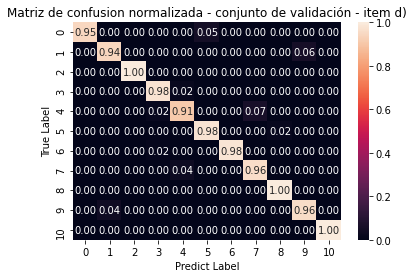

In [ ]:
# Datos de la matriz de confusión:
Confusion=confusion_matrix(y_true, y_pred,normalize='true') 

# Matriz de confusión:
ax=sns.heatmap(Confusion, annot=True,fmt=".2f")
ax.set_title('Matriz de confusion normalizada - conjunto de validación - item d)')
plt.xlabel('Predict Label')
plt.ylabel('True Label')

# Accuracy:
Accuracy_d= metrics.accuracy_score(y_true, y_pred)
print('Accuracy: '+str(Accuracy_d))
print('')

**Accuracy para el conjunto de validación disminuye respecto al calculado para el conjunto de entrenamiento y el desempeño de la matriz de confusión para validación también disminuye respecto al de entrenamiento, lo cual concuerda con la teoría al clasificar datos nuevos con los cuales no se entreno.**

**e)**

In [ ]:
# Diseño de la red:
model_e = nn.Sequential(
          nn.Linear(48, 10),
          nn.ReLU(),
          nn.Linear(10, 10),
          nn.ReLU(),
          nn.Linear(10, 11)
)

In [ ]:
device = torch.device('cuda')

model_e = model_e.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_e.parameters(), lr=1e-3)

In [ ]:
lista_loss_epoca_train=[]
lista_loss_epoca_val=[]
T1=time.time()
for epoch in range(1000):
    try:
      model_e.train()
      # Train on the current epoch
      lista_loss_train=[]
      for i, data in enumerate(dataloader_train, 0):
          inputs = data["features"].to(device)
          labels = data["labels"].to(device)

          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = model_e(inputs)

          loss_train = criterion(outputs, labels) #Loss entrenamiento
          lista_loss_train.append(loss_train.item())
          loss_train.backward()
          optimizer.step()
      
      # Compute validation loss and accuracy for current epoch
      model_e.eval()

      with torch.no_grad():  
        lista_loss_val=[]
        for i, data in enumerate(dataloader_val, 0):
            inputs = data["features"].to(device)
            labels = data["labels"].to(device)

            outputs = model_e(inputs)
            loss_val = criterion(outputs, labels) #Loss validación
            lista_loss_val.append(loss_val.item())
                 
      lista_loss_epoca_train.append(np.mean(lista_loss_train))
      lista_loss_epoca_val.append(np.mean(lista_loss_val))

      # Imprimir: numero de época, loss de entrenamiento y loss de validación:
      sys.stdout.write("\rÉpoca %d , loss train: %.2f, loss validacion:%.2f"  %(epoch,lista_loss_epoca_train[epoch],lista_loss_epoca_val[epoch]))
      
      #Check Point pesos sinapticos cada 50 épocas:
      if epoch%50==0:
        name="epoch_e_"+str(epoch)
        torch.save(model_e,name)
        modelo_check_e=name  #Se guarda el ultimo modelo guardado
        epoca_check=epoch  #Se guarda la ultima epoca en donde se hizo check pointcorta para el grafico de Loss
      
      #Frenado overfitting:
      if epoch>=50:
        inicial_lista=lista_loss_epoca_val[epoch-50:epoch]
        final_lista=lista_loss_epoca_val[epoch-49:epoch+1]
        inicial=np.mean(inicial_lista)
        final=np.mean(final_lista)
        if final-inicial>0:
          #Fin de Entrenamiento
          break
      
      
    except KeyboardInterrupt:
      print("\nEntrenamiento interrumpido")

      break
    

print('\nEntrenamiento finalizado')

#Tiempo de entrenamiento:
T2=time.time()
Te=T2-T1
print('Tiempo de entrenamiento: ' + str(round(Te,1))+'[s]')

Época 162 , loss train: 0.14, loss validacion:0.16
Entrenamiento finalizado
Tiempo de entrenamiento: 10.1[s]


In [ ]:
# i)
print('Epoca ultimo Check Point: '+str(epoca_check))
print('Loss train ultimo Check Point: {:.2f} '.format(lista_loss_epoca_train[epoca_check]))  
print('Loss validacion ultimo Check Point: {:.2f} '.format(lista_loss_epoca_val[epoca_check]))
print('Tiempo de entrenamiento: '+str(round(Te,1))+'[s]')


Epoca ultimo Check Point: 150
Loss train ultimo Check Point: 0.14 
Loss validacion ultimo Check Point: 0.16 
Tiempo de entrenamiento: 10.1[s]


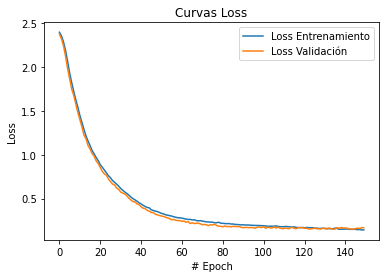

In [ ]:
# ii)
epocas=[i for i in range(0,epoca_check)]
plt.plot(epocas,lista_loss_epoca_train[0:epoca_check])
plt.plot(epocas,lista_loss_epoca_val[0:epoca_check])
plt.legend(["Loss Entrenamiento","Loss Validación"], loc ="upper right")
plt.title('Curvas Loss')
plt.xlabel('# Epoch')
plt.ylabel('Loss')
plt.show()

**Curva Loss de validación es mayor a la curva Loss de entrenamiento, lo cual concuerda con la teoría.**

In [ ]:
# iii)
# Conjunto de entrenamiento:
model_e_check = torch.load(modelo_check_e) #Carga el modelo
y_pred=[]
y_true=[]
model_e_check.eval()
with torch.no_grad():
  for i, data in enumerate(dataloader_train, 0):
    inputs = data["features"].to(device) # Features
    labels = data["labels"].to(device)   # Labels
    true=labels.cpu().tolist()    # Guardamos los labels como listas en la variable "true"
    y_true.extend(true)  # Luego esta se incorpora a la lista "y_true"
    outputs = model_e_check(inputs) # Se obtiene la salida de la red neuronal
    output=outputs.cpu().numpy()  # outputs se transforman de tensor a numpy
    list=[]
    for i in range(len(output)): # Para cada fila de la matriz clasificacion, se obtiene el indice asociado al valor maximo de la salida
        list.append(np.argmax(output[i])) # Se obtiene la clasificacion, la cual se guarda en "list"
    y_pred.extend(list) # Una vez que la lista es llenada con el batch completo, esta es concatenada en "y_pred"

Accuracy: 0.9545173267326733



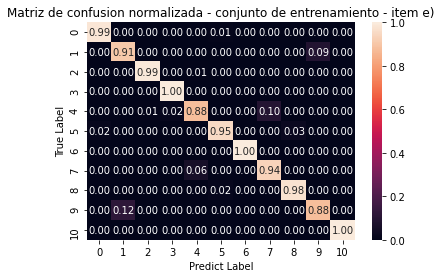

In [ ]:
# Datos de la matriz de confusión:
Confusion=confusion_matrix(y_true, y_pred,normalize='true') 

# Matriz de confusión:
ax=sns.heatmap(Confusion, annot=True,fmt=".2f")
ax.set_title('Matriz de confusion normalizada - conjunto de entrenamiento - item e)')
plt.xlabel('Predict Label')
plt.ylabel('True Label')

# Accuracy:
Accuracy_e= metrics.accuracy_score(y_true, y_pred)
print('Accuracy: '+str(Accuracy_e))
print('')

In [ ]:
# iv)
# Conjunto de validación:
model_e_check = torch.load(modelo_check_e) #Carga el modelo
y_pred=[]
y_true=[]
model_e_check.eval()
with torch.no_grad():
  for i, data in enumerate(dataloader_val, 0):
    inputs = data["features"].to(device) # Features
    labels = data["labels"].to(device)   # Labels
    true=labels.cpu().tolist()    # Guardamos los labels como listas en la variable "true"
    y_true.extend(true)  # Luego esta se incorpora a la lista "y_true"
    outputs = model_e_check(inputs) # Se obtiene la salida de la red neuronal
    output=outputs.cpu().numpy()  # outputs se transforman de tensor a numpy
    list=[]
    for i in range(len(output)): # Para cada fila de la matriz clasificacion, se obtiene el indice asociado al valor maximo de la salida
        list.append(np.argmax(output[i])) # Se obtiene la clasificacion, la cual se guarda en "list"
    y_pred.extend(list) # Una vez que la lista es llenada con el batch completo, esta es concatenada en "y_pred"

Accuracy: 0.9422066549912435



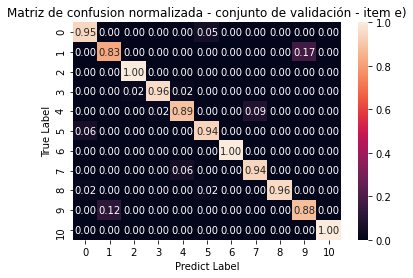

In [ ]:
# Datos de la matriz de confusión:
Confusion=confusion_matrix(y_true, y_pred,normalize='true') 

# Matriz de confusión:
ax=sns.heatmap(Confusion, annot=True,fmt=".2f")
ax.set_title('Matriz de confusion normalizada - conjunto de validación - item e)')
plt.xlabel('Predict Label')
plt.ylabel('True Label')

# Accuracy:
Accuracy_e= metrics.accuracy_score(y_true, y_pred)
print('Accuracy: '+str(Accuracy_e))
print('')

**Accuracy para el conjunto de validación disminuye respecto al calculado para el conjunto de entrenamiento y el desempeño de la matriz de confusión para validación también disminuye respecto al de entrenamiento, lo cual concuerda con la teoría al clasificar datos nuevos con los cuales no se entreno.**

**f)**

In [ ]:
# Diseño de la red:
model_f = nn.Sequential(
          nn.Linear(48, 40),
          nn.ReLU(),
          nn.Linear(40, 40),
          nn.ReLU(),
          nn.Linear(40, 11)
)

In [ ]:
device = torch.device('cuda')

model_f = model_f.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_f.parameters(), lr=1e-3)

In [ ]:
lista_loss_epoca_train=[]
lista_loss_epoca_val=[]
T1=time.time()
for epoch in range(1000):
    try:
      model_f.train()
      # Train on the current epoch
      lista_loss_train=[]
      for i, data in enumerate(dataloader_train, 0):
          inputs = data["features"].to(device)
          labels = data["labels"].to(device)

          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = model_f(inputs)

          loss_train = criterion(outputs, labels) #Loss entrenamiento
          lista_loss_train.append(loss_train.item())
          loss_train.backward()
          optimizer.step()
      
      # Compute validation loss and accuracy for current epoch
      model_f.eval()

      with torch.no_grad():  
        lista_loss_val=[]
        for i, data in enumerate(dataloader_val, 0):
            inputs = data["features"].to(device)
            labels = data["labels"].to(device)

            outputs = model_f(inputs)
            loss_val = criterion(outputs, labels) #Loss validación
            lista_loss_val.append(loss_val.item())
                 
      lista_loss_epoca_train.append(np.mean(lista_loss_train))
      lista_loss_epoca_val.append(np.mean(lista_loss_val))

      # Imprimir: numero de época, loss de entrenamiento y loss de validación:
      sys.stdout.write("\rÉpoca %d , loss train: %.2f, loss validacion:%.2f"  %(epoch,lista_loss_epoca_train[epoch],lista_loss_epoca_val[epoch]))
      
      #Check Point pesos sinapticos cada 50 épocas:
      if epoch%50==0:
        name="epoch_f_"+str(epoch)
        torch.save(model_f,name)
        modelo_check_f=name  #Se guarda el ultimo modelo guardado
        epoca_check=epoch  #Se guarda la ultima epoca en donde se hizo check pointcorta para el grafico de Loss
      
      #Frenado overfitting:
      if epoch>=50:
        inicial_lista=lista_loss_epoca_val[epoch-50:epoch]
        final_lista=lista_loss_epoca_val[epoch-49:epoch+1]
        inicial=np.mean(inicial_lista)
        final=np.mean(final_lista)
        if final-inicial>0:
          #Fin de Entrenamiento
          break
      
      
    except KeyboardInterrupt:
      print("\nEntrenamiento interrumpido")

      break
    

print('\nEntrenamiento finalizado')

#Tiempo de entrenamiento:
T2=time.time()
Tf=T2-T1
print('Tiempo de entrenamiento: ' + str(round(Tf,1))+'[s]')

Época 91 , loss train: 0.02, loss validacion:0.16
Entrenamiento finalizado
Tiempo de entrenamiento: 5.4[s]


In [ ]:
# i)
print('Epoca ultimo Check Point: '+str(epoca_check))
print('Loss train ultimo Check Point: {:.2f} '.format(lista_loss_epoca_train[epoca_check]))  
print('Loss validacion ultimo Check Point: {:.2f} '.format(lista_loss_epoca_val[epoca_check]))
print('Tiempo de entrenamiento: '+str(round(Tf,1))+'[s]')


Epoca ultimo Check Point: 50
Loss train ultimo Check Point: 0.07 
Loss validacion ultimo Check Point: 0.13 
Tiempo de entrenamiento: 5.4[s]


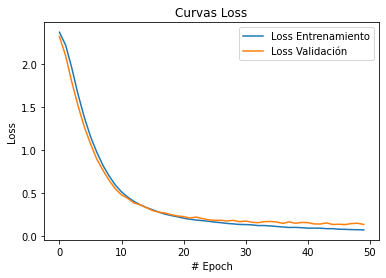

In [ ]:
# ii)
epocas=[i for i in range(0,epoca_check)]
plt.plot(epocas,lista_loss_epoca_train[0:epoca_check])
plt.plot(epocas,lista_loss_epoca_val[0:epoca_check])
plt.legend(["Loss Entrenamiento","Loss Validación"], loc ="upper right")
plt.title('Curvas Loss')
plt.xlabel('# Epoch')
plt.ylabel('Loss')
plt.show()

**Curva Loss de validación es mayor a la curva Loss de entrenamiento, lo cual concuerda con la teoría.**

In [ ]:
# iii)
# Conjunto de entrenamiento:
model_f_check = torch.load(modelo_check_f) #Carga el modelo
y_pred=[]
y_true=[]
model_f_check.eval()
with torch.no_grad():
  for i, data in enumerate(dataloader_train, 0):
    inputs = data["features"].to(device) # Features
    labels = data["labels"].to(device)   # Labels
    true=labels.cpu().tolist()    # Guardamos los labels como listas en la variable "true"
    y_true.extend(true)  # Luego esta se incorpora a la lista "y_true"
    outputs = model_f_check(inputs) # Se obtiene la salida de la red neuronal
    output=outputs.cpu().numpy()  # outputs se transforman de tensor a numpy
    list=[]
    for i in range(len(output)): # Para cada fila de la matriz clasificacion, se obtiene el indice asociado al valor maximo de la salida
        list.append(np.argmax(output[i])) # Se obtiene la clasificacion, la cual se guarda en "list"
    y_pred.extend(list) # Una vez que la lista es llenada con el batch completo, esta es concatenada en "y_pred"

Accuracy: 0.9845297029702971



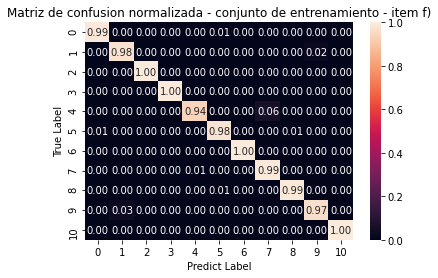

In [ ]:
# Datos de la matriz de confusión:
Confusion=confusion_matrix(y_true, y_pred,normalize='true') 

# Matriz de confusión:
ax=sns.heatmap(Confusion, annot=True,fmt=".2f")
ax.set_title('Matriz de confusion normalizada - conjunto de entrenamiento - item f)')
plt.xlabel('Predict Label')
plt.ylabel('True Label')

# Accuracy:
Accuracy_f= metrics.accuracy_score(y_true, y_pred)
print('Accuracy: '+str(Accuracy_f))
print('')

In [ ]:
# iv)
# Conjunto de validación:
model_f_check = torch.load(modelo_check_f) #Carga el modelo
y_pred=[]
y_true=[]
model_f_check.eval()
with torch.no_grad():
  for i, data in enumerate(dataloader_val, 0):
    inputs = data["features"].to(device) # Features
    labels = data["labels"].to(device)   # Labels
    true=labels.cpu().tolist()    # Guardamos los labels como listas en la variable "true"
    y_true.extend(true)  # Luego esta se incorpora a la lista "y_true"
    outputs = model_f_check(inputs) # Se obtiene la salida de la red neuronal
    output=outputs.cpu().numpy()  # outputs se transforman de tensor a numpy
    list=[]
    for i in range(len(output)): # Para cada fila de la matriz clasificacion, se obtiene el indice asociado al valor maximo de la salida
        list.append(np.argmax(output[i])) # Se obtiene la clasificacion, la cual se guarda en "list"
    y_pred.extend(list) # Una vez que la lista es llenada con el batch completo, esta es concatenada en "y_pred"

Accuracy: 0.9614711033274956



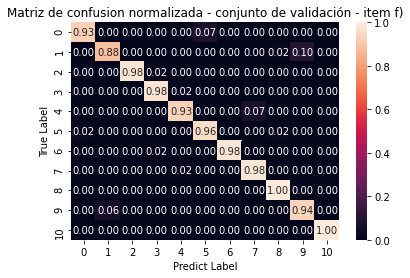

In [ ]:
# Datos de la matriz de confusión:
Confusion=confusion_matrix(y_true, y_pred,normalize='true') 

# Matriz de confusión:
ax=sns.heatmap(Confusion, annot=True,fmt=".2f")
ax.set_title('Matriz de confusion normalizada - conjunto de validación - item f)')
plt.xlabel('Predict Label')
plt.ylabel('True Label')

# Accuracy:
Accuracy_f= metrics.accuracy_score(y_true, y_pred)
print('Accuracy: '+str(Accuracy_f))
print('')

**Accuracy para el conjunto de validación disminuye respecto al calculado para el conjunto de entrenamiento y el desempeño de la matriz de confusión para validación también disminuye respecto al de entrenamiento, lo cual concuerda con la teoría al clasificar datos nuevos con los cuales no se entreno.**

**Parte 3**

Usando la mejor red encontrada en validación (aquella con mayor accuracy en validación), calcule la 
matriz de confusión normalizada y el accuracy normalizado, usando el conjunto de prueba.

In [ ]:
# Tabla Acurracies validación:
M={'Red Neuronal':{},'Accuracy':{}}
M=pd.DataFrame(M)
M['Red Neuronal']=['Red Neuronal '+i for i in ['a)','b)','c)','d)','e)','f)']]
M['Accuracy']=[Accuracy_a,Accuracy_b,Accuracy_c,Accuracy_d,Accuracy_e,Accuracy_f]


In [ ]:
M

,Red Neuronal,Accuracy
0,Red Neuronal a),0.942207
1,Red Neuronal b),0.966725
2,Red Neuronal c),0.931699
3,Red Neuronal d),0.970228
4,Red Neuronal e),0.942207
5,Red Neuronal f),0.961471


In [ ]:
# Discriminación del mejor modelo según Accuracy:
modelos=[model_a_check,model_b_check ,model_c_check ,model_d_check ,model_e_check ,model_f_check] #Lista de los modelos de su ultimo Check Point
best_indice=np.argmax(M['Accuracy'])  #Indice del modelo con mayor Accuracy
model_final=modelos[best_indice] #Definición del mejor modelo
# Print mejor red:
print('La mejor Red Neuronal fue: '+M['Red Neuronal'][best_indice])

La mejor Red Neuronal fue: Red Neuronal d)


In [ ]:
# Conjunto de test:
y_pred=[]
y_true=[]
model_final.eval()
with torch.no_grad():
  for i, data in enumerate(dataloader_test, 0):
    inputs = data["features"].to(device) # Features
    labels = data["labels"].to(device)   # Labels
    true=labels.cpu().tolist()    # Guardamos los labels como listas en la variable "true"
    y_true.extend(true)  # Luego esta se incorpora a la lista "y_true"
    outputs = model_final(inputs) # Se obtiene la salida de la red neuronal
    output=outputs.cpu().numpy()  # outputs se transforman de tensor a numpy
    list=[]
    for i in range(len(output)): # Para cada fila de la matriz clasificacion, se obtiene el indice asociado al valor maximo de la salida
        list.append(np.argmax(output[i])) # Se obtiene la clasificacion, la cual se guarda en "list"
    y_pred.extend(list) # Una vez que la lista es llenada con el batch completo, esta es concatenada en "y_pred"

Accuracy: 0.9581614614024749



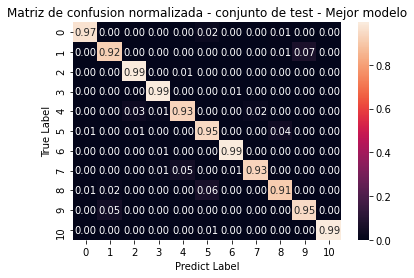

In [ ]:
# Datos de la matriz de confusión:
Confusion=confusion_matrix(y_true, y_pred,normalize='true') 

# Matriz de confusión:
ax=sns.heatmap(Confusion, annot=True,fmt=".2f")
ax.set_title('Matriz de confusion normalizada - conjunto de test - Mejor modelo')
plt.xlabel('Predict Label')
plt.ylabel('True Label')

# Accuracy:
Accuracy_test= metrics.accuracy_score(y_true, y_pred)
print('Accuracy: '+str(Accuracy_test))
print('')

**Parte 4**

Análisis de los resultados obtenidos:

a) Explique los efectos de variar la cantidad de neuronas en la capa oculta y como esto afecta el 
desempeño de la red.  

b) Explique los efectos de variar la cantidad de capas ocultas y como esto afecta el desempeño de 
la red. 

c) Explique el efecto de la función de activación y como esto afecta el desempeño de la red. 

d) Analice los siguientes puntos: tiempos de entrenamiento, matrices de confusión y accuracies de 
las arquitecturas probadas en validación. 

e) Analice la matriz de confusión y el accuracy en el conjunto de prueba, respecto a los obtenidos 
en el conjunto de validación.


In [ ]:
# Tabla Resumen:
M1={'Item':{},'Función de Activación':{},'# Neuronas en la Capa Oculta':{},'# Capas Ocultas':{},'Tiempo de Entrenamiento':{},'Accuracy Validación':{}}
M1=pd.DataFrame(M1)
M1['Item']=['a)','b)','c)','d)','e)','f)']
M1['Función de Activación']=['ReLU','ReLU','Tanh','Tanh','ReLU','ReLU']
M1['# Neuronas en la Capa Oculta']=[10,40,10,40,10,40]
M1['# Capas Ocultas']=[1,1,1,1,2,2]
M1['Accuracy Validación']=[Accuracy_a,Accuracy_b,Accuracy_c,Accuracy_d,Accuracy_e,Accuracy_f]
M1['Tiempo de Entrenamiento']=[Ta,Tb,Tc,Td,Te,Tf]


In [ ]:
M1

,Item,Función de Activación,# Neuronas en la Capa Oculta,# Capas Ocultas,Tiempo de Entrenamiento,Accuracy Validación
0,a),ReLU,10,1,13.866658,0.942207
1,b),ReLU,40,1,8.459074,0.966725
2,c),Tanh,10,1,14.059775,0.931699
3,d),Tanh,40,1,10.646480,0.970228
4,e),ReLU,10,2,10.130429,0.942207
5,f),ReLU,40,2,5.449395,0.961471


**a)** **A partir de la tabla anterior, se puede apreciar que el efecto que tiene aumentar el número de neuronas por capa es reducir el tiempo de aprendizaje y aumentar el desempeño de la red en terminos de Accuracy. Esto se asocia a la analogía con redes neuronales biológicas en donde mientras hayan más neuronas y por tanto mayores conexiones sinápticas la capacidad de aprendizaje mejorará.**

**b)** **Comparando los items a) y b) con los items e) y f) se observa que el efecto que tiene el aumentar el número de capas ocultas es que los tiempos de entrenamiento disminuyen al igual que el desempeño de la red pero en un pequeño porcentaje.**

**c)** **Comparando los desempeños de ReLU y Tanh, se observa  un leve aumento en el desempeño de la red cuando se utiliza la función Tanh en el item d, sin embargo disminuye en el item c). Esta variabilidad de los desempeños se asocia al valor inicial de los pesos sinápticos que afecta el resultado final del entrenamiento.** 

**d)** **A partir de la tabla anterior, respecto a los tiempos de entrenamiento se observa que al cambiar la función de activación de ReLU a Tanh aumentan los tiempos de entrenamiento, lo cual se asocia a que las derivadas de la función ReLU son más sencillas ya que tienen 2 valores posibles, 0 o el valor de la pendiente. Por otro lado, al aumentar el número de neuronas o de capas el tiempo de entrenamiento disminuye, lo cual se asocia a que hay mayores conexiones sinapticas que permiten un proceso de aprendizaje más óptimo y por tanto más rápido.**

**Respecto a las matrices de confusión, las que presentan mejores desempeños son las de los item b), d) y f), y las que presentan peores desempeños son a),  c) y e), en donde se observa por ejemplo que el item e) presenta problemas para clasificar la clase 4 y 7. Y se observa que la falla clase 10 es detectada con 100% de exito.**

**Finalmente, en cuanto a Acuracies, se observa que mejora al aumentar el número de capas o número de neuronas, lo cual se asocia a que el proceso de aprendizaje mejora al aumentar el número de conexiones sinápticas. Por otro lado, al variar las funciones de activación no es claro el efecto de la función Tanh, pero si el número de neuronas o capas aumentará se esperaría que el desempeño disminuya con Tanh producto de fenómeno "Desvanecimiento del Gradiente".** 

**e)** **A partir de la Parte 3, se observa que la matriz de confusión para el conjunto de test tuvo un muy buen desempeño, ya que los elementos de su diagonal, son todos mayores a 0.9. Además la matriz presenta un desempeño de clasificación muy similar al del conjunto de validación, lo cual tiene sentido ya que ambos conjuntos no fueron usados para su entrenamiento.**

**Finalmente, respecto a el Accuracy, presentan valores muy similares, lo cual al igual que lo mencionado anteriormente, tiene sentido ya que ambos conjuntos no fueron usados en el proceso de entrenamiento.** 

# **Conclusiones:**

**En esta tarea se aprendio a entrenar una red neuronal y a implementar un código que evite el Overfitting. También se comprendio el efecto que tiene el número de neuronas,número de capas ocultas y funciones de activación en los tiempos de entrenamiento y desempeño de la red neuronal. Por otro lado, se logro corroborar el poder las redes neuronales observando los altos valores de las matrices de confusión en su diagonal y accuracies en general.**

**En cuanto a objetivos y resultados, se puede decir que se cumplio a cabalidad con todos los requerimientos de la tarea y los resultados obtenidos concuerdan con la teoría, como por ejemplo el hecho de que disminuyan los tiempos de entrenamiento al aumentar el número de capas o de neuronas o usar la función de activación ReLU debido a sus derivadas constantes.**

**En cuanto a dificultades, la mayor dificultad fue entender el código base para agregarle nuevo código para implementar otras funcionalidades.**

**Finalmente la mejor solución fue la arquitectura del item d) de la parte 1, sin embargo este podría cambiar al ejecutar el código y se podria obtener como mejor modelo el item d) o incluso el item b). Esto se asocia a que los pesos sinápticos iniciales al ser elegidos de forma aleatoria afectan el desempeño final de cada modelo.**

**En este caso no hay modo de mejorar el desempeño de los algoritmos, ya que se utilizaron librerias en donde los códigos de programación estan predefinidos.**

In [ ]:
!pwd

/content


In [ ]:
%cd ../

/


In [ ]:
from google.colab import drive  #Se uso para no subir el archivo cada vez que se avanzaba en la tarea
drive.mount('/content/drive')

In [ ]:
#Carpeta:
%cd /content/drive/MyDrive/Colab Notebooks 

In [ ]:
#Install:
!sudo apt-get install texlive-xetex texlive-fonts-recommended texlive-generic-recommended

In [ ]:
#A PDF:
!jupyter nbconvert --to pdf tarea4ic.ipynb